In [ ]:
cd drive/MyDrive/CV-3

/content/drive/MyDrive/CV-3


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

In [ ]:
img1=cv2.imread('images/1.jpg')
img2=cv2.imread('images/2.jpg')

In [ ]:
gray_img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

sift = cv2.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(gray_img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray_img2, None)

img1_with_keypoints = cv2.drawKeypoints(img1, keypoints1, None)
img2_with_keypoints = cv2.drawKeypoints(img2, keypoints2, None)

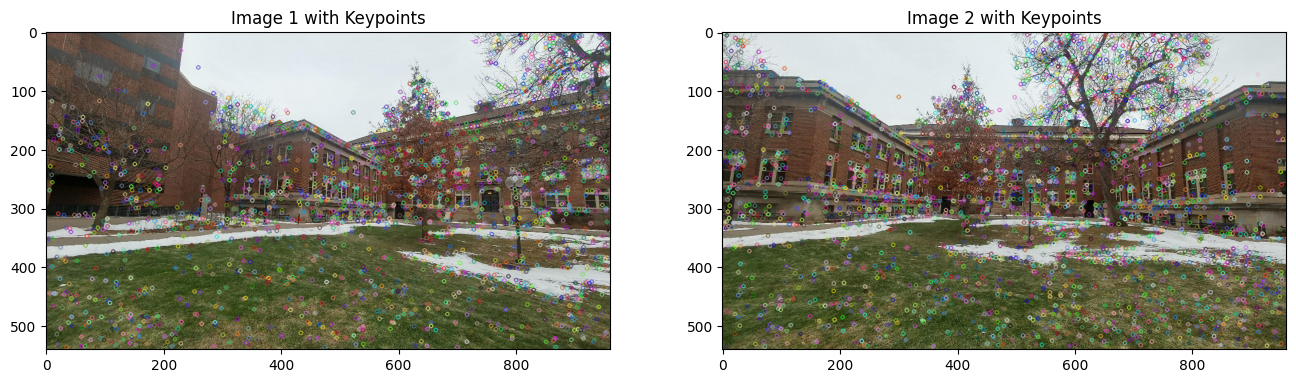

In [ ]:
ig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(cv2.cvtColor(img1_with_keypoints,cv2.COLOR_BGR2RGB))
axes[0].set_title('Image 1 with Keypoints')
axes[1].imshow(cv2.cvtColor(img2_with_keypoints,cv2.COLOR_BGR2RGB))
axes[1].set_title('Image 2 with Keypoints')

plt.show()


In [ ]:
descriptors1 = descriptors1.astype(np.uint8)
descriptors2 = descriptors2.astype(np.uint8)

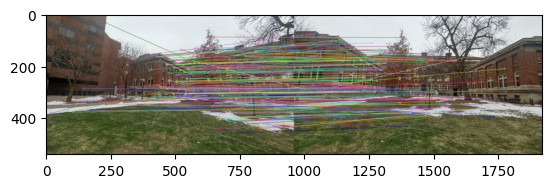

In [ ]:
# Initialize BruteForce matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors using BruteForce
matches_bf = bf.match(descriptors1, descriptors2)
no_of_matches = sorted(matches_bf,key=lambda x:x.distance)

# Draw matches
matched_image_bf = cv2.drawMatches(img1, keypoints1, img2, keypoints2, no_of_matches[:200], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(cv2.cvtColor(matched_image_bf,cv2.COLOR_BGR2RGB))

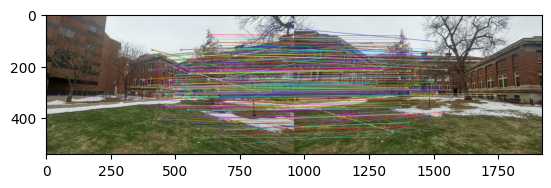

In [ ]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1,descriptors2,k=2)

# Apply ratio test
good = []
for m,n in matches:
  if m.distance < 0.75*n.distance:
    good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,keypoints1,img2,keypoints2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv2.cvtColor(img3,cv2.COLOR_BGR2RGB))

In [ ]:
len(no_of_matches)

957

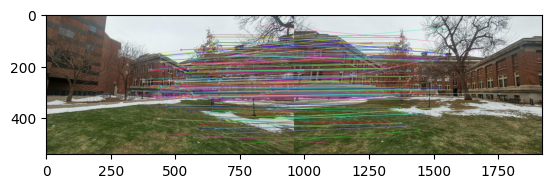

In [ ]:
# Initialize FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match descriptors using FLANN
matches_flann = flann.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to select good matches
good_matches_flann = []
for m, n in matches_flann:
    if m.distance < 0.7 * n.distance:
        good_mtches_flann.append(m)

matched_image_flann = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches_flann, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv2.cvtColor(matched_image_flann,cv2.COLOR_BGR2RGB))

In [ ]:
# Extract keypoints from good matches
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches_flann]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches_flann]).reshape(-1, 1, 2)

# Compute Homography matrix using RANSAC
homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
homography

array([[-7.22365858e+01,  2.37988667e+00,  2.58647049e+04],
       [-2.18874966e+01, -4.45669889e+01,  1.35665031e+04],
       [-7.51066570e-02, -1.11714408e-03,  1.00000000e+00]])

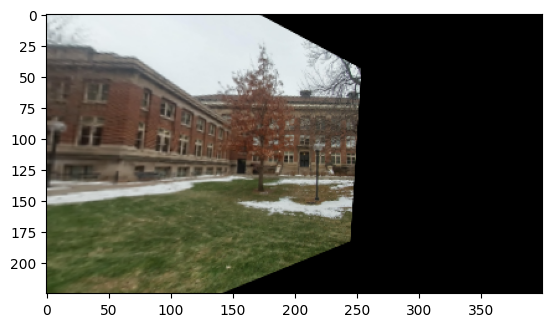

In [ ]:
height, width = gray_img2.shape
aligned_image1 = cv2.warpPerspective(img1, homography, (width, height))
plt.imshow(cv2.cvtColor(aligned_image1,cv2.COLOR_BGR2RGB))


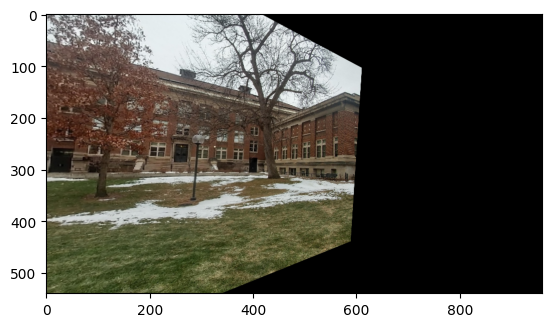

In [ ]:
height, width = gray_img1.shape
aligned_image2 = cv2.warpPerspective(img2, homography, (width, height))
plt.imshow(cv2.cvtColor(aligned_image2,cv2.COLOR_BGR2RGB))

In [ ]:
panorama_width = img2.shape[1] + aligned_image1.shape[1]
panorama_height = max(img2.shape[0], aligned_image1.shape[0])
panorama = np.zeros((panorama_height, panorama_width, 3), dtype=np.uint8)

# Copy image2 to the panorama canvas
panorama[:img2.shape[0], :img2.shape[1],:img2.shape[2]] = img2

# Warp aligned_image1 and overlay it onto the panorama canvas
aligned_image1_warped = cv2.warpPerspective(img1, homography, (panorama_width, panorama_height))
panorama_mask = np.all(aligned_image1_warped == 0, axis=2)
panorama[~panorama_mask] = aligned_image1_warped[~panorama_mask]

In [ ]:
panorama = np.concatenate((aligned_image1, img2), axis=1)

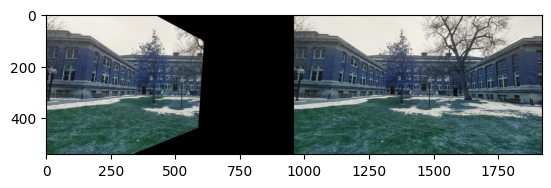

In [ ]:
dst = cv2.warpPerspective(img1,homography,((img1.shape[1] + img2.shape[1]), img2.shape[0])) #wraped image
dst[0:img2.shape[0], img2.shape[1]:] = img1 #stitched image

plt.imshow(dst)
plt.show()

STITCHER_OK: 0
STATUS: 0


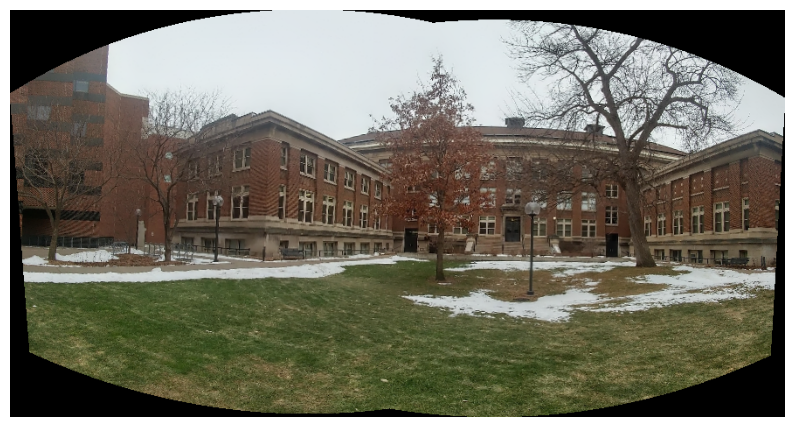

In [ ]:
stitcher = cv2.Stitcher_create()
status, panaroma_with_crop = stitcher.stitch((img1, img2))
if status != cv2.STITCHER_OK:
    print('Failed to stitch images')
else:
    panaroma_with_crop = cv2.cvtColor(panaroma_with_crop, cv2.COLOR_BGR2RGB)
    panaroma_with_crop = panaroma_with_crop.astype(np.float32) / 255.0

    # Display stitched result
    plt.figure(figsize=[10,6])
    plt.imshow(panaroma_with_crop)
    plt.axis('off')
    plt.show()



In [ ]:
import os
folder_path='images'
Images = []
ImageNames = os.listdir(folder_path)
Sorted_images = []
for ImageName in ImageNames:
    if ImageName.lower().endswith(".jpg"):
        Sorted_images.append(ImageName)
Sorted_images.sort()
for ImageName in Sorted_images:
    image = cv2.imread(os.path.join(folder_path, ImageName))
    Images.append(image)



['8.jpg', '4.jpg', '5.jpg', '7.jpg', '2.jpg', '3.jpg', '6.jpg', '1.jpg']

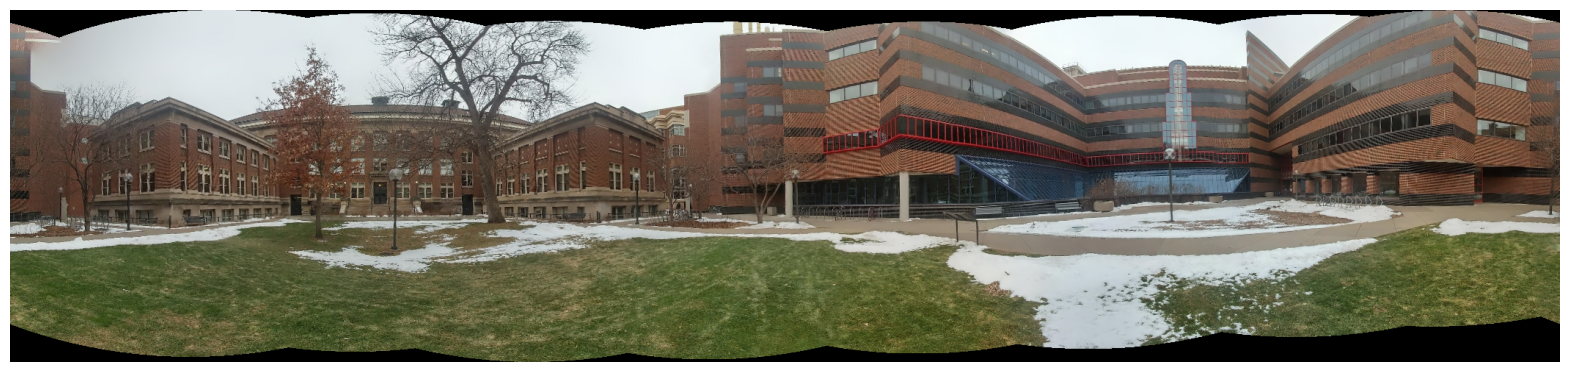

In [ ]:
# Create a stitcher object
stitcher = cv2.Stitcher_create()

# Attempt to stitch the images
status, result_BGR = stitcher.stitch(Images)

# Check if stitching was successful
if status == cv2.Stitcher_OK:
    # Convert result to RGB and normalize pixel values
    result_RGB = cv2.cvtColor(result_BGR, cv2.COLOR_BGR2RGB)
    result_RGB = result_RGB.astype(np.float32) / 255.0

    # Display stitched result
    plt.figure(figsize=[20, 10])
    plt.imshow(result_RGB)
    plt.axis('off')
    plt.show()
elif status == cv2.Stitcher_ERR_NEED_MORE_IMGS:
    print("Need more images to stitch.")
elif status == cv2.Stitcher_ERR_HOMOGRAPHY_EST_FAIL:
    print("Homography estimation failed.")
elif status == cv2.Stitcher_ERR_CAMERA_PARAMS_ADJUST_FAIL:
    print("Camera parameter adjustment failed.")
else:
    print("Stitching failed for unknown reasons.")
